##### 导入所需包

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

##### 数据预处理

In [2]:
data            = pd.read_csv("./dataset/iris.csv")

###### 修改数据集

In [3]:
data['Species'] = pd.factorize(data.Species)[0]  ## 将鸢尾花的类别从字符串转化为数值

###### 从数据集中选取X Y

In [4]:
X               = data.iloc[:,1:-1].values

In [5]:
Y               = data.iloc[:,-1].values

###### 使用train_test_split切分数据集

In [6]:
from sklearn.model_selection import train_test_split

In [7]:
train_x,test_x,train_y,test_y = train_test_split(X,Y)

###### 将切分好的数据及转化为Tensor

In [8]:
train_x = torch.from_numpy(train_x).type(torch.float32)
train_y = torch.from_numpy(train_y).type(torch.int64)
test_x  = torch.from_numpy(test_x).type(torch.float32)
test_y  = torch.from_numpy(test_y).type(torch.int64)  # 注意数据类型

###### 将Tensor使用DataLoader与TensorData包装

In [9]:
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset

In [10]:
batch_size = 8

In [11]:
train_ds = TensorDataset(train_x,train_y)
train_dl = DataLoader(train_ds,batch_size = batch_size,shuffle=True)

In [12]:
test_ds  = TensorDataset(test_x,test_y)
test_dl  = DataLoader(test_ds,batch_size  = batch_size)

##### 创建多分类模型

In [13]:
from torch import nn
from torch.nn import functional as F

In [14]:
class Model(nn.Module):
    
    def __init__(self):
        super().__init__()
        self.linear_1 = nn.Linear(4,32)
        self.linear_2 = nn.Linear(32,32)
        self.linear_3 = nn.Linear(32,3)
    
    def forward(self,input):
        x = self.linear_1(input)
        x = F.relu(x)
        x = self.linear_2(x)
        x = F.relu(x)
        x = self.linear_3(x)  ## 这里要进行多分类不进行激活
        return x

##### 初始化模型

In [15]:
model = Model()

##### 定义损失函数

In [16]:
loss_fn = nn.CrossEntropyLoss()

###### 模型的返回结果及其形式的简单测试

In [17]:
input_batch,label_batch = next(iter(train_dl))
print(input_batch.shape,label_batch.shape)

torch.Size([8, 4]) torch.Size([8])


In [18]:
y_pred  =  model(input_batch)

In [19]:
y_pred.shape  # 预测结果中那个值最大，那么最终的结果就是几

torch.Size([8, 3])

In [20]:
y_pred

tensor([[ 0.4493,  0.0240, -0.5465],
        [-0.0529, -0.0944, -0.2070],
        [ 0.3407, -0.0340, -0.4467],
        [ 0.2596,  0.0364, -0.5512],
        [ 0.2079, -0.0028, -0.3980],
        [ 0.3127, -0.0087, -0.4784],
        [ 0.3860, -0.0238, -0.4037],
        [ 0.2210, -0.0143, -0.5396]], grad_fn=<AddmmBackward0>)

In [21]:
torch.argmax(y_pred,dim=1) #在第二个维度 纵向找到最大值，充当预测结果

tensor([0, 0, 0, 0, 0, 0, 0, 0])

##### 创建并训练模型

In [22]:
# 求解多分类问题的正确率
def accuracy(y_pred,y_true):
    y_pred = torch.argmax(y_pred,dim=1)   #找到结果中的最大值对应的下标
    acc    = (y_pred == y_true).float().mean() #将该下标作为预测结果，计算准
    return acc                            #确率

In [23]:
train_loss = []
train_acc  = []
test_loss  = []
test_acc   = []
epochs     = 20
optim      = torch.optim.Adam(model.parameters(),lr = 0.0001)

In [24]:
for epoch in range(epochs):
    for x,y in train_dl:
        y_pred = model(x)
        loss   = loss_fn(y_pred,y)
        optim.zero_grad()
        loss.backward()
        optim.step()
    with torch.no_grad():
        epoch_accuracy      = accuracy(model(train_x),train_y)
        epoch_loss          = loss_fn(model(train_x),train_y).data
        
        epoch_test_accuracy = accuracy(model(test_x),test_y)
        epoch_test_loss     = loss_fn(model(test_x),test_y).data
        
        print("epoch:",epoch,"loss: ",round(epoch_loss.item(),3),
                             "accuracy: ",round(epoch_accuracy.item(),3),
                             "test_loss: ",round(epoch_test_loss.item(),3),
                             "test_accuracy: ",round(epoch_test_accuracy.item(),3)
             )
        train_loss.append(epoch_loss)
        train_acc.append(epoch_accuracy)
        test_loss.append(epoch_test_loss)
        test_acc.append(epoch_test_accuracy)

epoch: 0 loss:  1.246 accuracy:  0.304 test_loss:  1.181 test_accuracy:  0.368
epoch: 1 loss:  1.21 accuracy:  0.286 test_loss:  1.153 test_accuracy:  0.395
epoch: 2 loss:  1.179 accuracy:  0.446 test_loss:  1.131 test_accuracy:  0.553
epoch: 3 loss:  1.154 accuracy:  0.536 test_loss:  1.113 test_accuracy:  0.684
epoch: 4 loss:  1.134 accuracy:  0.607 test_loss:  1.099 test_accuracy:  0.711
epoch: 5 loss:  1.115 accuracy:  0.616 test_loss:  1.086 test_accuracy:  0.763
epoch: 6 loss:  1.098 accuracy:  0.625 test_loss:  1.074 test_accuracy:  0.763
epoch: 7 loss:  1.084 accuracy:  0.625 test_loss:  1.065 test_accuracy:  0.763
epoch: 8 loss:  1.07 accuracy:  0.625 test_loss:  1.058 test_accuracy:  0.763
epoch: 9 loss:  1.058 accuracy:  0.616 test_loss:  1.051 test_accuracy:  0.763
epoch: 10 loss:  1.047 accuracy:  0.598 test_loss:  1.043 test_accuracy:  0.711
epoch: 11 loss:  1.037 accuracy:  0.616 test_loss:  1.038 test_accuracy:  0.605
epoch: 12 loss:  1.028 accuracy:  0.652 test_loss:  

##### 可视化训练过程

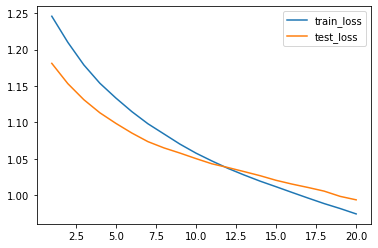

In [25]:
plt.plot(range(1,epochs+1),train_loss,label = "train_loss")
plt.plot(range(1,epochs+1),test_loss,label = "test_loss")
plt.legend()

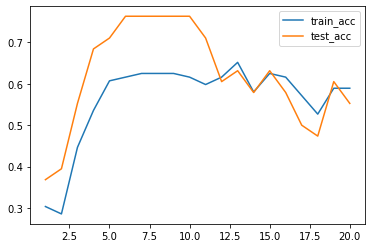

In [26]:
plt.plot(range(1,epochs+1),train_acc,label = "train_acc")
plt.plot(range(1,epochs+1),test_acc,label = "test_acc")
plt.legend()

#### 模型训练模板

In [27]:
# 1. 创建输入（dataloader）
# 2. 创建模型（model）
# 3  创建损失函数

In [28]:
def fit(model,trainloader,testloader,epoch):
    
    correct = 0       # 记录正确率
    total   = 0       # 记录训练样本总数量
    running_loss = 0
    for x,y in trainloader:
        y_pred = model(x)
        loss   = loss_fn(y_pred,y)
        optim.zero_grad()
        loss.backward()
        optim.step()
        with torch.no_grad():
            y_pred = torch.argmax(y_pred,dim=1)
            correct+=(y_pred == y).sum().item()
            total  += y.size(0)
            running_loss += loss.item()
    
    epoch_loss = running_loss / len(trainloader.dataset) # 得到每一个样本在本epoch下的平均loss
    epoch_acc  = correct / total # 得到整个样本的平均预测正确率
    
    test_correct      = 0       # 记录正确率
    test_total        = 0       # 记录训练样本总数量
    test_running_loss = 0
    
    with torch.no_grad():
        for x,y in trainloader:
            y_pred = model(x)
            loss   = loss_fn(y_pred,y)
            y_pred = torch.argmax(y_pred,dim=1)
            test_correct+=(y_pred == y).sum().item()
            test_total  += y.size(0)
            test_running_loss += loss.item()
    
    epoch_test_loss = test_running_loss / len(testloader.dataset) # 得到每一个样本在本epoch下的平均loss
    epoch_test_acc  = test_correct / test_total # 得到整个样本的平均预测正确率
    
    print(
            "epoch:","\t",epoch,"\t",
            "loss: ","\t",round(epoch_loss,3),"\t",
            "accuracy: ","\t",round(epoch_acc,3),"\t",
            "test_loss: ","\t",round(epoch_test_loss,3),"\t",
            "test_accuracy: ","\t",round(epoch_test_acc,3),"\t"
        )
    return epoch_loss,epoch_acc,epoch_test_loss,epoch_test_acc

#### 自定义FIT函数的调用示例

In [29]:
model = Model()
optim = torch.optim.Adam(model.parameters(),lr = 0.0001)

In [30]:
epochs= 500

In [31]:
train_loss = []
train_acc  = []
test_loss  = []
test_acc   = []

In [32]:
for epoch in range(epochs):
    epoch_loss,epoch_acc,epoch_test_loss,epoch_test_acc = fit(model,train_dl,test_dl,epoch)
    train_loss.append(epoch_loss)
    
    train_acc.append(epoch_acc)
    test_loss.append(epoch_test_loss)
    test_acc.append(epoch_test_acc)

epoch: 	 0 	 loss:  	 0.147 	 accuracy:  	 0.366 	 test_loss:  	 0.43 	 test_accuracy:  	 0.366 	
epoch: 	 1 	 loss:  	 0.145 	 accuracy:  	 0.366 	 test_loss:  	 0.422 	 test_accuracy:  	 0.366 	
epoch: 	 2 	 loss:  	 0.142 	 accuracy:  	 0.366 	 test_loss:  	 0.416 	 test_accuracy:  	 0.366 	
epoch: 	 3 	 loss:  	 0.14 	 accuracy:  	 0.366 	 test_loss:  	 0.41 	 test_accuracy:  	 0.366 	
epoch: 	 4 	 loss:  	 0.138 	 accuracy:  	 0.366 	 test_loss:  	 0.405 	 test_accuracy:  	 0.366 	
epoch: 	 5 	 loss:  	 0.136 	 accuracy:  	 0.366 	 test_loss:  	 0.399 	 test_accuracy:  	 0.366 	
epoch: 	 6 	 loss:  	 0.134 	 accuracy:  	 0.366 	 test_loss:  	 0.393 	 test_accuracy:  	 0.366 	
epoch: 	 7 	 loss:  	 0.133 	 accuracy:  	 0.366 	 test_loss:  	 0.388 	 test_accuracy:  	 0.366 	
epoch: 	 8 	 loss:  	 0.131 	 accuracy:  	 0.366 	 test_loss:  	 0.384 	 test_accuracy:  	 0.366 	
epoch: 	 9 	 loss:  	 0.13 	 accuracy:  	 0.366 	 test_loss:  	 0.38 	 test_accuracy:  	 0.366 	
epoch: 	 10 	 l

epoch: 	 85 	 loss:  	 0.063 	 accuracy:  	 0.777 	 test_loss:  	 0.186 	 test_accuracy:  	 0.768 	
epoch: 	 86 	 loss:  	 0.063 	 accuracy:  	 0.768 	 test_loss:  	 0.184 	 test_accuracy:  	 0.768 	
epoch: 	 87 	 loss:  	 0.062 	 accuracy:  	 0.768 	 test_loss:  	 0.183 	 test_accuracy:  	 0.768 	
epoch: 	 88 	 loss:  	 0.062 	 accuracy:  	 0.768 	 test_loss:  	 0.181 	 test_accuracy:  	 0.768 	
epoch: 	 89 	 loss:  	 0.061 	 accuracy:  	 0.786 	 test_loss:  	 0.18 	 test_accuracy:  	 0.786 	
epoch: 	 90 	 loss:  	 0.061 	 accuracy:  	 0.804 	 test_loss:  	 0.178 	 test_accuracy:  	 0.804 	
epoch: 	 91 	 loss:  	 0.06 	 accuracy:  	 0.812 	 test_loss:  	 0.177 	 test_accuracy:  	 0.821 	
epoch: 	 92 	 loss:  	 0.06 	 accuracy:  	 0.821 	 test_loss:  	 0.175 	 test_accuracy:  	 0.821 	
epoch: 	 93 	 loss:  	 0.059 	 accuracy:  	 0.821 	 test_loss:  	 0.174 	 test_accuracy:  	 0.821 	
epoch: 	 94 	 loss:  	 0.059 	 accuracy:  	 0.821 	 test_loss:  	 0.173 	 test_accuracy:  	 0.821 	
epo

epoch: 	 167 	 loss:  	 0.035 	 accuracy:  	 0.964 	 test_loss:  	 0.104 	 test_accuracy:  	 0.964 	
epoch: 	 168 	 loss:  	 0.035 	 accuracy:  	 0.964 	 test_loss:  	 0.103 	 test_accuracy:  	 0.964 	
epoch: 	 169 	 loss:  	 0.035 	 accuracy:  	 0.964 	 test_loss:  	 0.103 	 test_accuracy:  	 0.964 	
epoch: 	 170 	 loss:  	 0.035 	 accuracy:  	 0.964 	 test_loss:  	 0.102 	 test_accuracy:  	 0.964 	
epoch: 	 171 	 loss:  	 0.035 	 accuracy:  	 0.964 	 test_loss:  	 0.101 	 test_accuracy:  	 0.964 	
epoch: 	 172 	 loss:  	 0.034 	 accuracy:  	 0.964 	 test_loss:  	 0.1 	 test_accuracy:  	 0.964 	
epoch: 	 173 	 loss:  	 0.034 	 accuracy:  	 0.964 	 test_loss:  	 0.1 	 test_accuracy:  	 0.964 	
epoch: 	 174 	 loss:  	 0.034 	 accuracy:  	 0.964 	 test_loss:  	 0.099 	 test_accuracy:  	 0.964 	
epoch: 	 175 	 loss:  	 0.034 	 accuracy:  	 0.964 	 test_loss:  	 0.098 	 test_accuracy:  	 0.964 	
epoch: 	 176 	 loss:  	 0.033 	 accuracy:  	 0.964 	 test_loss:  	 0.098 	 test_accuracy:  	 0.

epoch: 	 251 	 loss:  	 0.021 	 accuracy:  	 0.982 	 test_loss:  	 0.061 	 test_accuracy:  	 0.973 	
epoch: 	 252 	 loss:  	 0.021 	 accuracy:  	 0.973 	 test_loss:  	 0.06 	 test_accuracy:  	 0.973 	
epoch: 	 253 	 loss:  	 0.02 	 accuracy:  	 0.973 	 test_loss:  	 0.06 	 test_accuracy:  	 0.982 	
epoch: 	 254 	 loss:  	 0.02 	 accuracy:  	 0.973 	 test_loss:  	 0.06 	 test_accuracy:  	 0.973 	
epoch: 	 255 	 loss:  	 0.02 	 accuracy:  	 0.973 	 test_loss:  	 0.059 	 test_accuracy:  	 0.973 	
epoch: 	 256 	 loss:  	 0.02 	 accuracy:  	 0.973 	 test_loss:  	 0.059 	 test_accuracy:  	 0.973 	
epoch: 	 257 	 loss:  	 0.02 	 accuracy:  	 0.973 	 test_loss:  	 0.059 	 test_accuracy:  	 0.973 	
epoch: 	 258 	 loss:  	 0.02 	 accuracy:  	 0.973 	 test_loss:  	 0.058 	 test_accuracy:  	 0.973 	
epoch: 	 259 	 loss:  	 0.02 	 accuracy:  	 0.973 	 test_loss:  	 0.058 	 test_accuracy:  	 0.973 	
epoch: 	 260 	 loss:  	 0.02 	 accuracy:  	 0.973 	 test_loss:  	 0.058 	 test_accuracy:  	 0.973 	
e

epoch: 	 334 	 loss:  	 0.014 	 accuracy:  	 0.982 	 test_loss:  	 0.042 	 test_accuracy:  	 0.982 	
epoch: 	 335 	 loss:  	 0.014 	 accuracy:  	 0.982 	 test_loss:  	 0.041 	 test_accuracy:  	 0.982 	
epoch: 	 336 	 loss:  	 0.014 	 accuracy:  	 0.982 	 test_loss:  	 0.041 	 test_accuracy:  	 0.982 	
epoch: 	 337 	 loss:  	 0.014 	 accuracy:  	 0.982 	 test_loss:  	 0.041 	 test_accuracy:  	 0.982 	
epoch: 	 338 	 loss:  	 0.014 	 accuracy:  	 0.982 	 test_loss:  	 0.041 	 test_accuracy:  	 0.982 	
epoch: 	 339 	 loss:  	 0.014 	 accuracy:  	 0.982 	 test_loss:  	 0.041 	 test_accuracy:  	 0.982 	
epoch: 	 340 	 loss:  	 0.014 	 accuracy:  	 0.982 	 test_loss:  	 0.041 	 test_accuracy:  	 0.982 	
epoch: 	 341 	 loss:  	 0.014 	 accuracy:  	 0.982 	 test_loss:  	 0.04 	 test_accuracy:  	 0.982 	
epoch: 	 342 	 loss:  	 0.014 	 accuracy:  	 0.982 	 test_loss:  	 0.04 	 test_accuracy:  	 0.982 	
epoch: 	 343 	 loss:  	 0.014 	 accuracy:  	 0.982 	 test_loss:  	 0.04 	 test_accuracy:  	 0

epoch: 	 417 	 loss:  	 0.011 	 accuracy:  	 0.982 	 test_loss:  	 0.032 	 test_accuracy:  	 0.982 	
epoch: 	 418 	 loss:  	 0.011 	 accuracy:  	 0.982 	 test_loss:  	 0.032 	 test_accuracy:  	 0.982 	
epoch: 	 419 	 loss:  	 0.011 	 accuracy:  	 0.982 	 test_loss:  	 0.032 	 test_accuracy:  	 0.982 	
epoch: 	 420 	 loss:  	 0.011 	 accuracy:  	 0.982 	 test_loss:  	 0.032 	 test_accuracy:  	 0.982 	
epoch: 	 421 	 loss:  	 0.011 	 accuracy:  	 0.991 	 test_loss:  	 0.032 	 test_accuracy:  	 0.982 	
epoch: 	 422 	 loss:  	 0.011 	 accuracy:  	 0.982 	 test_loss:  	 0.032 	 test_accuracy:  	 0.982 	
epoch: 	 423 	 loss:  	 0.011 	 accuracy:  	 0.982 	 test_loss:  	 0.032 	 test_accuracy:  	 0.982 	
epoch: 	 424 	 loss:  	 0.011 	 accuracy:  	 0.982 	 test_loss:  	 0.032 	 test_accuracy:  	 0.982 	
epoch: 	 425 	 loss:  	 0.011 	 accuracy:  	 0.982 	 test_loss:  	 0.032 	 test_accuracy:  	 0.982 	
epoch: 	 426 	 loss:  	 0.011 	 accuracy:  	 0.982 	 test_loss:  	 0.031 	 test_accuracy:  

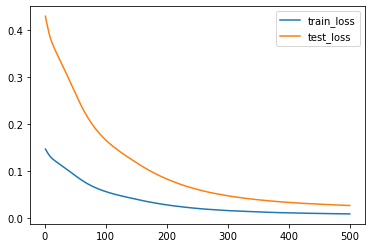

In [33]:
plt.plot(range(1,epochs+1),train_loss,label = "train_loss")
plt.plot(range(1,epochs+1),test_loss,label  = "test_loss")
plt.legend()

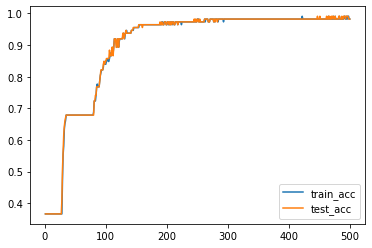

In [34]:
plt.plot(range(1, epochs+1), train_acc, label='train_acc')
plt.plot(range(1, epochs+1), test_acc, label ='test_acc')
plt.legend()